In [1]:
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.21-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post6-cp310-cp310-linux_x86_64.whl size=5860627 sha256=4affffff38ef322d20a7e5c3524c5f6e5392e04a26b6c91da7ec5a4f3031eb19
  Stored in directory: /root/.cache/pip/wheels/7d/ef/82/425eeca860fd20527d2a9159fc5920b591144d34300a46a216
Successfully built cmfrec


In [2]:
!pip install threadpoolctl

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
ratings_small.csv		   user_topologycal_properties2.csv
user_topologycal_properties10.csv  user_topologycal_properties3.csv
user_topologycal_properties11.csv  user_topologycal_properties4.csv
user_topologycal_properties12.csv  user_topologycal_properties5.csv
user_topologycal_properties13.csv  user_topologycal_properties6.csv
user_topologycal_properties14.csv  user_topologycal_properties7.csv
user_topologycal_properties15.csv  user_topologycal_properties8.csv
user_topologycal_properties1.csv   user_topologycal_properties9.csv


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmfrec import CMF
import statistics as stat
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [18]:
df_ratings = pd.read_csv('gdrive/MyDrive/Datasets/ratings_small.csv', usecols=[0, 1, 2])
M = df_ratings['UserId'].nunique()
N = df_ratings['ItemId'].nunique()
movie_mapper = dict(zip(np.unique(df_ratings["ItemId"]), list(range(0,N))))
user_mapper = dict(zip(np.unique(df_ratings["UserId"]), list(range(0,M))))
movie_inv_mapper = dict(zip(list(range(0,N)), np.unique(df_ratings["ItemId"])))
user_inv_mapper = dict(zip(list(range(N,N+M)), np.unique(df_ratings["UserId"])))

df_ratings['UserId'] = df_ratings['UserId'].apply(lambda x: user_mapper[x])
df_ratings['ItemId'] = df_ratings['ItemId'].apply(lambda x: movie_mapper[x])

In [19]:
df_ratings.describe()

,UserId,ItemId,Rating
count,100004.000000,100004.000000,100004.000000
mean,346.011310,2691.887445,3.543608
std,195.163838,2375.936209,1.058064
min,0.000000,0.000000,0.500000
25%,181.000000,832.000000,3.000000
50%,366.000000,1916.500000,4.000000
75%,519.000000,4121.000000,4.000000
max,670.000000,9065.000000,5.000000


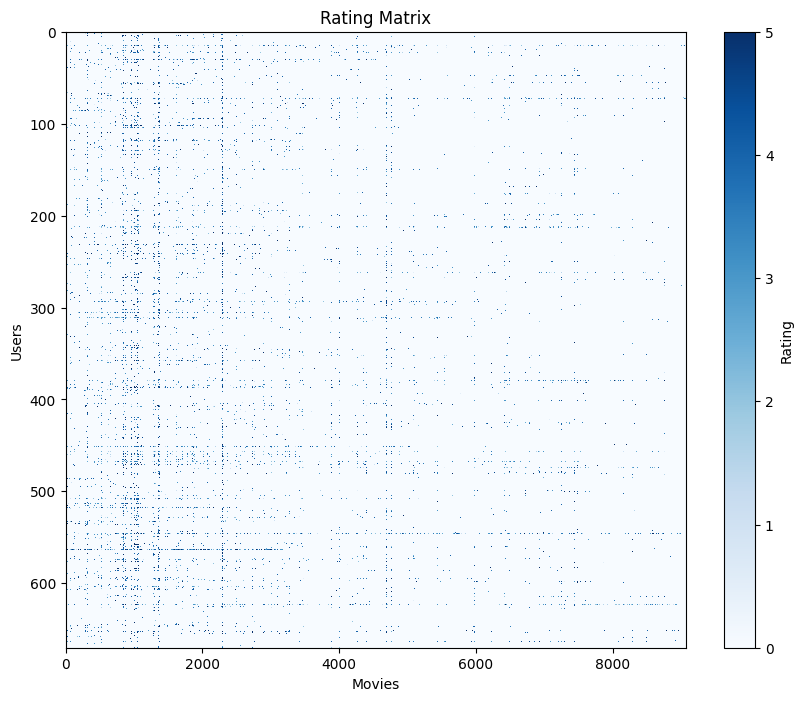

In [20]:
from scipy.sparse import csr_matrix
row = df_ratings['UserId'].tolist()
col = df_ratings['ItemId'].tolist()
data = df_ratings['Rating'].tolist()
R = csr_matrix((data, (row, col)))
d=R.todense()
plt.figure(figsize = (10,8))
plt.imshow(d,interpolation='none',cmap='Blues', aspect='auto')
plt.xlabel("Movies")
plt.ylabel("Users")
plt.title("Rating Matrix")
cb = plt.colorbar()
cb.set_label('Rating')
plt.show()

<ipython-input-21-3850947874c3>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ratings_list, bins=b, hist=True, kde=True, color='darkorange', kde_kws={'linewidth': 3}, hist_kws={'color':'orange'})


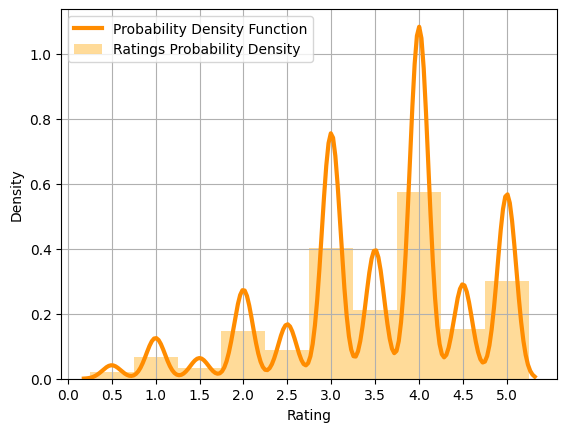

In [21]:
ratings_list = df_ratings['Rating'].tolist()
d = 1/2
left_of_first_bin = min(ratings_list) - d/2
right_of_last_bin = max(ratings_list) + d/2
b = np.arange(left_of_first_bin, right_of_last_bin + d, d)
plt.clf()
sns.distplot(ratings_list, bins=b, hist=True, kde=True, color='darkorange', kde_kws={'linewidth': 3}, hist_kws={'color':'orange'})
plt.xlabel("Rating")
plt.xticks(np.arange(0, 5.5, 0.5))
plt.legend(labels=['Probability Density Function','Ratings Probability Density'])
plt.grid()
plt.show()

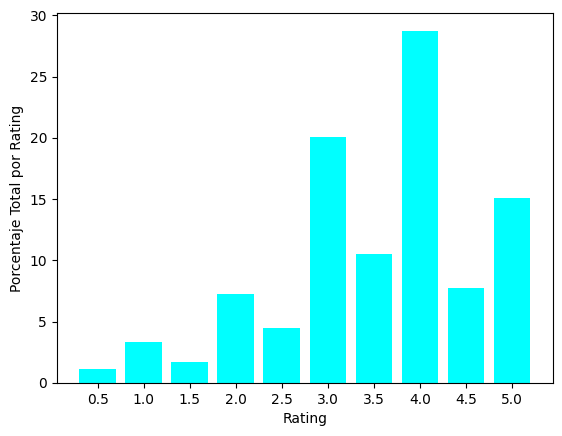

In [22]:
p = df_ratings.groupby('Rating')['Rating'].agg(['count'])
ratings = []
for i in np.arange(0.5, 5.5, 0.5):
    ratings.append(str(i))
rating_percentage = []
for i in range(len(p)):
    rating_percentage.append(p.iloc[i][0]*100 / p.sum()[0])

plt.clf()
plt.bar(ratings, rating_percentage, color="cyan")
plt.xlabel('Rating')
plt.ylabel('Porcentaje Total por Rating')
plt.show()

Grid search for the best parameters

In [23]:
# Search parameters
k_values = [10, 20, 30, 50, 100]  # Latent factors
lambda_values = [0.1, 1, 10, 50]  # Regularization parameter
HOLDOUT = 10

# Grid search
rmse_min = np.inf
best_params = None
for k_ in k_values:
  for l_ in lambda_values:
    h_rmse = []
    for i in range(HOLDOUT):
      # Train test split
      users_train, users_test = train_test_split(df_ratings['UserId'].unique(), test_size=0.2)
      items_train, items_test = train_test_split(df_ratings['ItemId'].unique(), test_size=0.2)
      ratings_train = df_ratings[(df_ratings['UserId'].isin(users_train)) & (df_ratings['ItemId'].isin(items_train))]
      ratings_test = df_ratings[(df_ratings['UserId'].isin(users_test)) & (df_ratings['ItemId'].isin(items_test))]

      # Train model
      model = CMF(method="als", k=k_, lambda_=l_, user_bias=True, verbose=False)
      model.fit(ratings_train)

      # Predictions
      predictions = model.predict(ratings_test['UserId'], ratings_test['ItemId'])

      # Calcular el RMSE y almacenarlo en h_rmse
      rmse = metrics.mean_squared_error(ratings_test['Rating'], predictions, squared=True)
      h_rmse.append(rmse)

    mean_rmse = np.mean(h_rmse)
    if mean_rmse < rmse_min:
      rmse_min = mean_rmse
      best_params = (k_, l_)

print("The best RMSE is {0} and is obtained with the parameters k={1} and lambda={2}".format(rmse_min, best_params[0], best_params[1]))

The best RMSE is 1.0819158647208416 and is obtained with the parameters k=100 and lambda=10


# Recommendation without user properties

In [33]:
HOLDOUT = 20
h_rmse = []
h_mae = []
h_r2 = []

for i in range(HOLDOUT):
  # Train test split
  users_train, users_test = train_test_split(df_ratings['UserId'].unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings['ItemId'].unique(), test_size=0.2)
  ratings_train = df_ratings[(df_ratings['UserId'].isin(users_train)) & (df_ratings['ItemId'].isin(items_train))]
  ratings_test = df_ratings[(df_ratings['UserId'].isin(users_test)) & (df_ratings['ItemId'].isin(items_test))]

  # Train model
  model = CMF(method="als", k=best_params[0], lambda_=best_params[1], user_bias=True, verbose=False)
  model.fit(ratings_train)

  # Predictions
  predictions = model.predict(ratings_test['UserId'], ratings_test['ItemId'])

  # Metrics
  rmse = metrics.mean_squared_error(ratings_test['Rating'], predictions, squared=True)
  mae = metrics.mean_absolute_error(ratings_test['Rating'], predictions)
  r2 = metrics.r2_score(ratings_test['Rating'], predictions)
  h_rmse.append(rmse)
  h_mae.append(mae)
  h_r2.append(r2)

#Algorithm analysis
mean_h_rmse_wo = stat.mean(h_rmse)
mean_h_mae_wo = stat.mean(h_mae)
mean_h_r2_wo = stat.mean(h_r2)
stdev_h_rmse = stat.stdev(h_rmse)
stdev_h_mae = stat.stdev(h_mae)
stdev_h_r2 = stat.stdev(h_r2)
print("Holdout Report")
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse_wo,mean_h_mae_wo,mean_h_r2_wo))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))

Holdout Report
Mean of RMSE, MAE, R2: 1.109710511286935, 0.8470523715508632, -0.007426053652789732
Standard deviation of RMSE, MAE, R2: 0.0445318212421298, 0.015391044077511958, 0.012283568057666163


# Recommendation using user properties (CMF)


Exponential Model

In [25]:
models = 100
h_rmse_expo, h_mae_expo, h_r2_expo = [], [], []

for i in range(models):
  filename = f"gdrive/MyDrive/Articulo/user_topo_proper_expo_{i}.csv"
  df_users = pd.read_csv(filename)

  # Normalize values
  df_users['degree'] = preprocessing.scale(df_users['degree'])
  df_users['betweenness'] = preprocessing.scale(df_users['betweenness'])
  df_users['community'] = preprocessing.scale(df_users['community'])
  df_users['eccentricity'] = preprocessing.scale(df_users['eccentricity'])
  df_users['farness'] = preprocessing.scale(df_users['farness'])

  # Train test split
  users_train, users_test = train_test_split(df_ratings['UserId'].unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings['ItemId'].unique(), test_size=0.2)
  ratings_train = df_ratings[(df_ratings['UserId'].isin(users_train)) & (df_ratings['ItemId'].isin(items_train))]
  ratings_test = df_ratings[(df_ratings['UserId'].isin(users_test)) & (df_ratings['ItemId'].isin(items_test))]

  # User properties
  user_attr_train = df_users.loc[df_users['UserId'].isin(ratings_train['UserId'].unique())]

  # Train model
  model = CMF(method="als", k=best_params[0], lambda_=best_params[1], user_bias=True, verbose=False)
  model.fit(X=ratings_train, U=user_attr_train)

  # Predictions
  predictions = model.predict(ratings_test['UserId'], ratings_test['ItemId'])

  # Metrics
  rmse = metrics.mean_squared_error(ratings_test['Rating'], predictions, squared=True)
  mae = metrics.mean_absolute_error(ratings_test['Rating'], predictions)
  r2 = metrics.r2_score(ratings_test['Rating'], predictions)
  h_rmse_expo.append(rmse)
  h_mae_expo.append(mae)
  h_r2_expo.append(r2)

# Algorithm analysis
mean_h_rmse = stat.mean(h_rmse_expo)
mean_h_mae = stat.mean(h_mae_expo)
mean_h_r2 = stat.mean(h_r2_expo)
stdev_h_rmse = stat.stdev(h_rmse_expo)
stdev_h_mae = stat.stdev(h_mae_expo)
stdev_h_r2 = stat.stdev(h_r2_expo)
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))

Mean of RMSE, MAE, R2: 1.1123765576273204, 0.8458383271521689, -0.006798447720585115
Standard deviation of RMSE, MAE, R2: 0.061779559762038076, 0.02361983228642918, 0.009238903805709988


Power-law model

In [26]:
models = 100
h_rmse_pow, h_mae_pow, h_r2_pow = [], [], []

for i in range(models):
  filename = f"gdrive/MyDrive/Articulo/user_topo_proper_pow_{i}.csv"
  df_users = pd.read_csv(filename)

  # Normalize values
  df_users['degree'] = preprocessing.scale(df_users['degree'])
  df_users['betweenness'] = preprocessing.scale(df_users['betweenness'])
  df_users['community'] = preprocessing.scale(df_users['community'])
  df_users['eccentricity'] = preprocessing.scale(df_users['eccentricity'])
  df_users['farness'] = preprocessing.scale(df_users['farness'])

  # Train test split
  users_train, users_test = train_test_split(df_ratings['UserId'].unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings['ItemId'].unique(), test_size=0.2)
  ratings_train = df_ratings[(df_ratings['UserId'].isin(users_train)) & (df_ratings['ItemId'].isin(items_train))]
  ratings_test = df_ratings[(df_ratings['UserId'].isin(users_test)) & (df_ratings['ItemId'].isin(items_test))]

  # User properties
  user_attr_train = df_users.loc[df_users['UserId'].isin(ratings_train['UserId'].unique())]

  # Train model
  model = CMF(method="als", k=best_params[0], lambda_=best_params[1], user_bias=True, verbose=False)
  model.fit(X=ratings_train, U=user_attr_train)

  # Predictions
  predictions = model.predict(ratings_test['UserId'], ratings_test['ItemId'])

  # Metrics
  rmse = metrics.mean_squared_error(ratings_test['Rating'], predictions, squared=True)
  mae = metrics.mean_absolute_error(ratings_test['Rating'], predictions)
  r2 = metrics.r2_score(ratings_test['Rating'], predictions)
  h_rmse_pow.append(rmse)
  h_mae_pow.append(mae)
  h_r2_pow.append(r2)

# Algorithm analysis
mean_h_rmse = stat.mean(h_rmse_pow)
mean_h_mae = stat.mean(h_mae_pow)
mean_h_r2 = stat.mean(h_r2_pow)
stdev_h_rmse = stat.stdev(h_rmse_pow)
stdev_h_mae = stat.stdev(h_mae_pow)
stdev_h_r2 = stat.stdev(h_r2_pow)
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))

Mean of RMSE, MAE, R2: 1.129386999720196, 0.8533961865789872, -0.0064006064599936695
Standard deviation of RMSE, MAE, R2: 0.07609808519815392, 0.027904992349373627, 0.009902625186236054


Rayleigh model

In [27]:
models = 100
h_rmse_ray, h_mae_ray, h_r2_ray = [], [], []

for i in range(models):
  filename = f"gdrive/MyDrive/Articulo/user_topo_proper_ray_{i}.csv"
  df_users = pd.read_csv(filename)

  # Normalize values
  df_users['degree'] = preprocessing.scale(df_users['degree'])
  df_users['betweenness'] = preprocessing.scale(df_users['betweenness'])
  df_users['community'] = preprocessing.scale(df_users['community'])
  df_users['eccentricity'] = preprocessing.scale(df_users['eccentricity'])
  df_users['farness'] = preprocessing.scale(df_users['farness'])

  # Train test split
  users_train, users_test = train_test_split(df_ratings['UserId'].unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings['ItemId'].unique(), test_size=0.2)
  ratings_train = df_ratings[(df_ratings['UserId'].isin(users_train)) & (df_ratings['ItemId'].isin(items_train))]
  ratings_test = df_ratings[(df_ratings['UserId'].isin(users_test)) & (df_ratings['ItemId'].isin(items_test))]

  # User properties
  user_attr_train = df_users.loc[df_users['UserId'].isin(ratings_train['UserId'].unique())]

  # Train model
  model = CMF(method="als", k=best_params[0], lambda_=best_params[1], user_bias=True, verbose=False)
  model.fit(X=ratings_train, U=user_attr_train)

  # Predictions
  predictions = model.predict(ratings_test['UserId'], ratings_test['ItemId'])

  # Metrics
  rmse = metrics.mean_squared_error(ratings_test['Rating'], predictions, squared=True)
  mae = metrics.mean_absolute_error(ratings_test['Rating'], predictions)
  r2 = metrics.r2_score(ratings_test['Rating'], predictions)
  h_rmse_ray.append(rmse)
  h_mae_ray.append(mae)
  h_r2_ray.append(r2)

# Algorithm analysis
mean_h_rmse = stat.mean(h_rmse_ray)
mean_h_mae = stat.mean(h_mae_ray)
mean_h_r2 = stat.mean(h_r2_ray)
stdev_h_rmse = stat.stdev(h_rmse_ray)
stdev_h_mae = stat.stdev(h_mae_ray)
stdev_h_r2 = stat.stdev(h_r2_ray)
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))

Mean of RMSE, MAE, R2: 1.1192213134781492, 0.8496483503552503, -0.007313182455493199
Standard deviation of RMSE, MAE, R2: 0.07524716113844133, 0.028242041944552064, 0.00978083951827737


# Results

In [28]:
alpha_0 = 1*10**-7
alpha_f = 1*10**-3
alpha_arrange_expo, h = np.linspace(alpha_0, alpha_f, num=100, retstep=True)

alpha_0 = 6
alpha_f = 12
alpha_arrange_pow, h = np.linspace(alpha_0, alpha_f, num=100, retstep=True)

alpha_0 = 1*10**-14
alpha_f = 1*10**-12
alpha_arrange_ray, h = np.linspace(alpha_0, alpha_f, num=100, retstep=True)

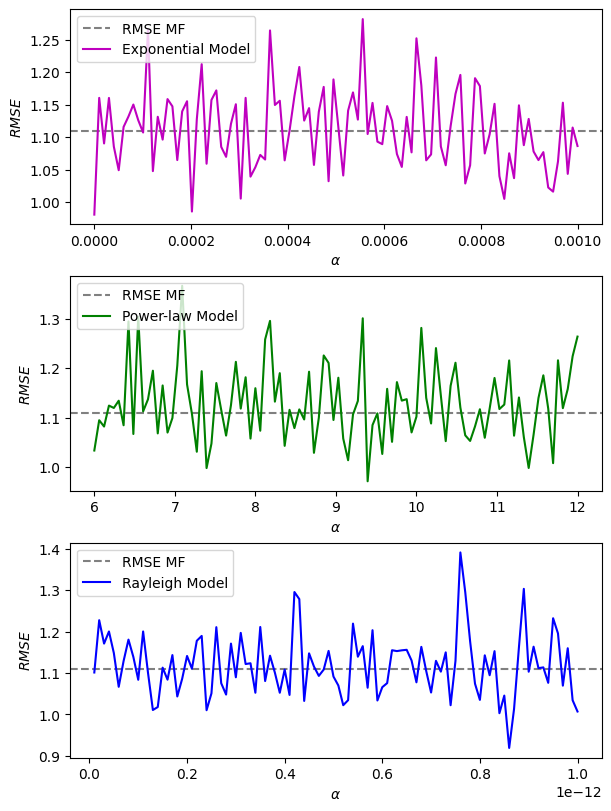

In [36]:
fig, axs = plt.subplots(3, figsize=(6,8), constrained_layout=True)

for ax in axs:
    ax.axhline(y=mean_h_rmse_wo, color='gray', linestyle='--', label='RMSE MF')

axs[0].plot(alpha_arrange_expo, h_rmse_expo, 'm', label='Exponential Model')
axs[0].set_xlabel("$\\alpha$")
axs[0].set_ylabel('$RMSE$')
axs[0].legend()
axs[1].plot(alpha_arrange_pow, h_rmse_pow, 'g', label='Power-law Model')
axs[1].set_xlabel("$\\alpha$")
axs[1].set_ylabel('$RMSE$')
axs[1].legend(loc='upper left')
axs[2].plot(alpha_arrange_ray, h_rmse_ray, 'b', label='Rayleigh Model')
axs[2].set_xlabel("$\\alpha$")
axs[2].set_ylabel('$RMSE$')
#axs[2].set_xscale('log')
axs[2].legend()



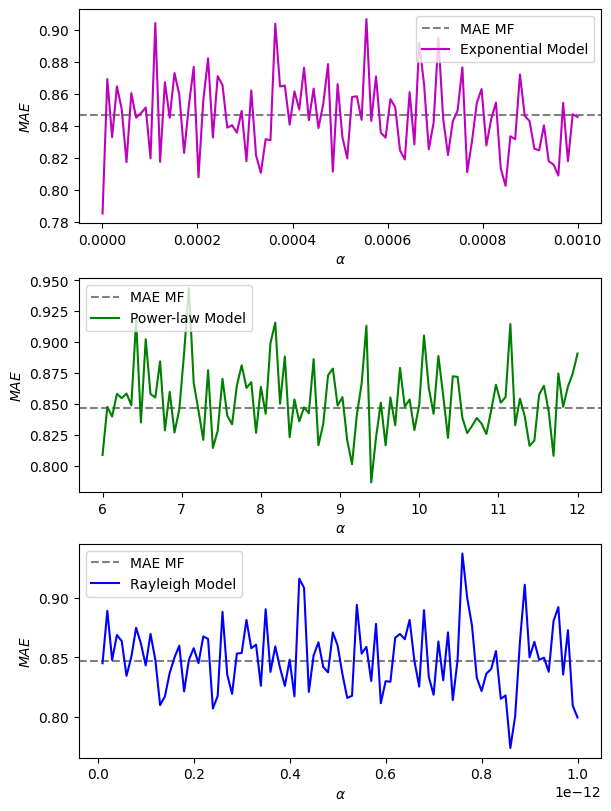

In [37]:
fig, axs = plt.subplots(3, figsize=(6,8), constrained_layout=True)

for ax in axs:
    ax.axhline(y=mean_h_mae_wo, color='gray', linestyle='--', label='MAE MF')

axs[0].plot(alpha_arrange_expo, h_mae_expo, 'm', label='Exponential Model')
axs[0].set_xlabel("$\\alpha$")
axs[0].set_ylabel('$MAE$')
axs[0].legend()
axs[1].plot(alpha_arrange_pow, h_mae_pow, 'g', label='Power-law Model')
axs[1].set_xlabel("$\\alpha$")
axs[1].set_ylabel('$MAE$')
axs[1].legend(loc='upper left')
axs[2].plot(alpha_arrange_ray, h_mae_ray, 'b', label='Rayleigh Model')
axs[2].set_xlabel("$\\alpha$")
axs[2].set_ylabel('$MAE$')
#axs[2].set_xscale('log')
axs[2].legend()

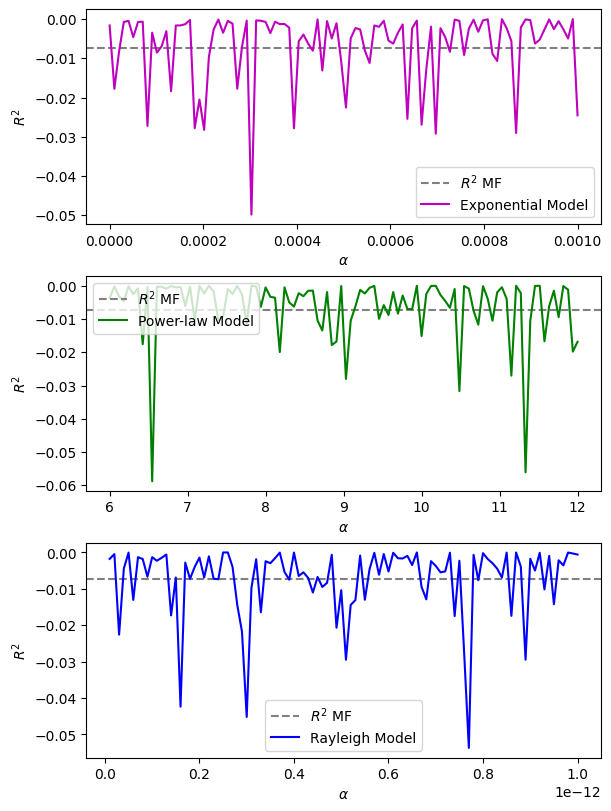

In [39]:
fig, axs = plt.subplots(3, figsize=(6,8), constrained_layout=True)

for ax in axs:
    ax.axhline(y=mean_h_r2_wo, color='gray', linestyle='--', label='$R^2$ MF')

axs[0].plot(alpha_arrange_expo, h_r2_expo, 'm', label='Exponential Model')
axs[0].set_xlabel("$\\alpha$")
axs[0].set_ylabel('$R^2$')
axs[0].legend()
axs[1].plot(alpha_arrange_pow, h_r2_pow, 'g', label='Power-law Model')
axs[1].set_xlabel("$\\alpha$")
axs[1].set_ylabel('$R^2$')
axs[1].legend(loc='upper left')
axs[2].plot(alpha_arrange_ray, h_r2_ray, 'b', label='Rayleigh Model')
axs[2].set_xlabel("$\\alpha$")
axs[2].set_ylabel('$R^2$')
#axs[2].set_xscale('log')
axs[2].legend()

In [40]:
#True for min False por max
def get_index(type_search, x):
  index = None
  if type_search: index = min(range(len(x)), key=x.__getitem__)
  else: index = max(range(len(x)), key=x.__getitem__)
  return index

i_min_expo = get_index(True, h_rmse_expo)
i_max_expo = get_index(False, h_rmse_expo)
print(f'El RMSE minimo para el modelo exponencial es {h_rmse_expo[i_min_expo]} obtenido con el alpha {alpha_arrange_expo[i_min_expo]}')
print(f'El RMSE maximo para el modelo exponencial es {h_rmse_expo[i_max_expo]} obtenido con el alpha {alpha_arrange_expo[i_max_expo]}')
i_min_pow = get_index(True, h_rmse_pow)
i_max_pow = get_index(False, h_rmse_pow)
print(f'El RMSE minimo para el modelo power-law es {h_rmse_pow[i_min_pow]} obtenido con el alpha {alpha_arrange_pow[i_min_pow]}')
print(f'El RMSE maximo para el modelo power-law es {h_rmse_pow[i_max_pow]} obtenido con el alpha {alpha_arrange_pow[i_max_pow]}')
i_min_ray = get_index(True, h_rmse_ray)
i_max_ray = get_index(False, h_rmse_ray)
print(f'El RMSE minimo para el modelo rayleigh es {h_rmse_ray[i_min_ray]} obtenido con el alpha {alpha_arrange_ray[i_min_ray]}')
print(f'El RMSE maximo para el modelo rayleigh es {h_rmse_ray[i_max_ray]} obtenido con el alpha {alpha_arrange_ray[i_max_ray]}')


El RMSE minimo para el modelo exponencial es 0.9804496472480491 obtenido con el alpha 1e-07
El RMSE maximo para el modelo exponencial es 1.2819377963843175 obtenido con el alpha 0.0005556
El RMSE minimo para el modelo power-law es 0.9717332012900062 obtenido con el alpha 9.393939393939394
El RMSE maximo para el modelo power-law es 1.3667514231044622 obtenido con el alpha 7.090909090909091
El RMSE minimo para el modelo rayleigh es 0.919191824301545 obtenido con el alpha 8.6e-13
El RMSE maximo para el modelo rayleigh es 1.3909247995806013 obtenido con el alpha 7.6e-13
